# Factor timing

In this section, we discuss a simple Momentum strategy to time the quantitative factors previsouly considers (Stock Momentum, Value, Size and the Market).

In [1]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from IPython.display import Image, display
from matplotlib import pyplot as plt
from skfin.backtesting import Backtester
from skfin.datasets_ import load_kf_returns
from skfin.mv_estimators import MeanVariance
from skfin.plot import bar, heatmap, line

from matplotlib import pyplot as plt

In [2]:
files = ["F-F_Research_Data_Factors", "F-F_Momentum_Factor"]
ret = pd.concat([load_kf_returns(c)["Monthly"] for c in files], axis=1).drop(
    "RF", axis=1
)[:"1999"]

INFO:skfin.dataloaders.cache:Loading from cache : data/F-F_Research_Data_Factors


INFO:skfin.dataloaders.cache:Loading from cache : data/F-F_Momentum_Factor


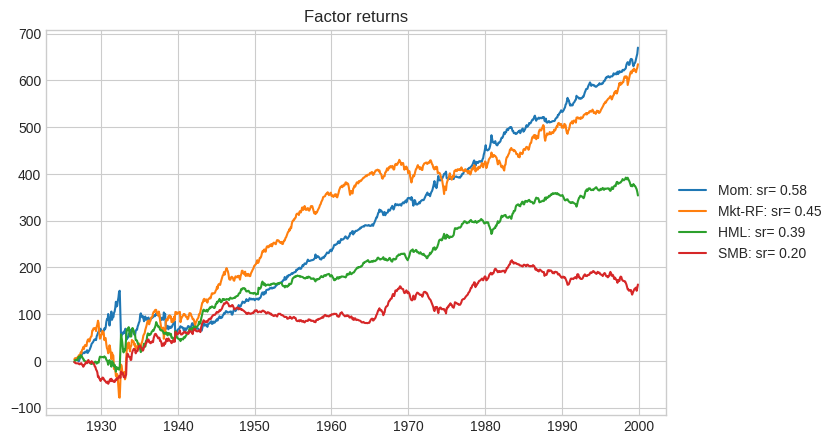

In [3]:
line(ret, cumsum=True, title="Factor returns")

As in the industry Momentum case, we use the previous 12-month returns as the prediction of returns.

In [4]:
def transform_X(df, window=12):
    return df.rolling(window=window).mean()


def transform_y(df):
    return df.shift(-1)


X = transform_X(ret)
y = transform_y(ret)

While in the sector rotation case, we imposed a "cash-neutrality constraint" (so that the sum of the positions on a given is zero and the strategy is long-short), this constraint is not necessary in the factor timing case. Below, we set the constraint vector `A` to `None` in the `MeanVariance` estimator. 

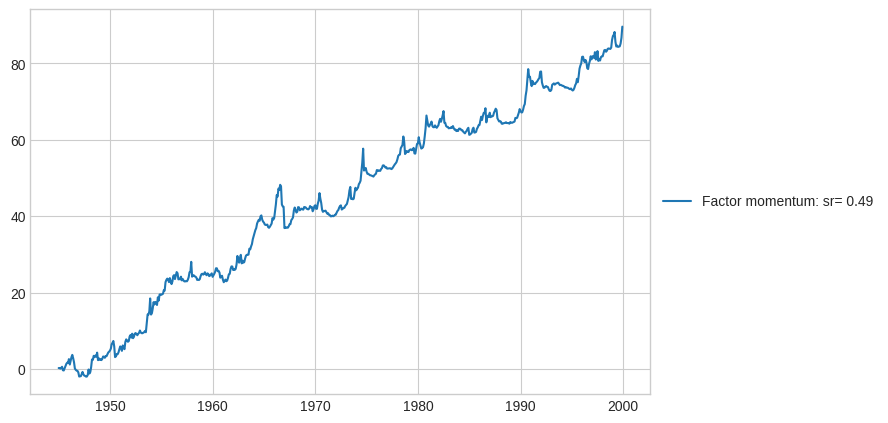

In [5]:
m = Backtester(estimator=MeanVariance(A=None), name="Factor momentum")
pnl_ = m.train(X, y, ret)
line(pnl_, cumsum=True)

Below we decompose the strategy pnl by the contribution of each asset. (We also divide the total pnl by the square-root of the number of assets so that all the pnl shown below have approximately the same standard devation.)

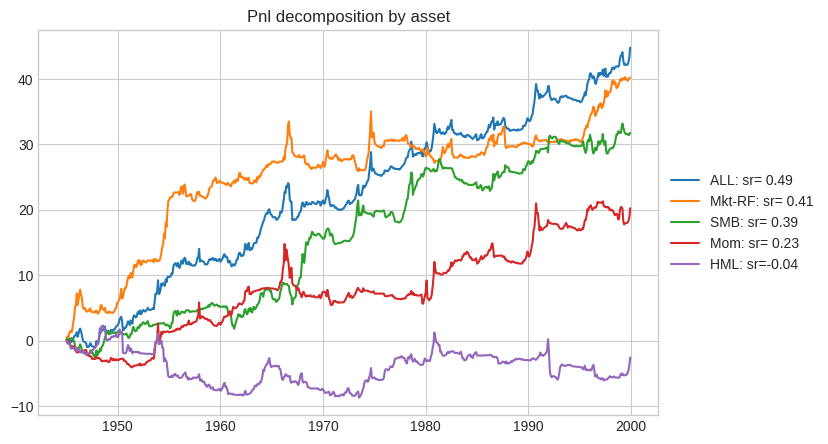

In [6]:
line(
    m.h_.shift(1)
    .mul(ret)
    .dropna(how="all", axis=0)
    .assign(ALL=lambda x: x.sum(axis=1).div(np.sqrt(ret.shape[1]))),
    cumsum=True,
    title="Pnl decomposition by asset",
)

The chart below shows the average positions on the factors is positive, but there is a significant standard deviation on the position. 

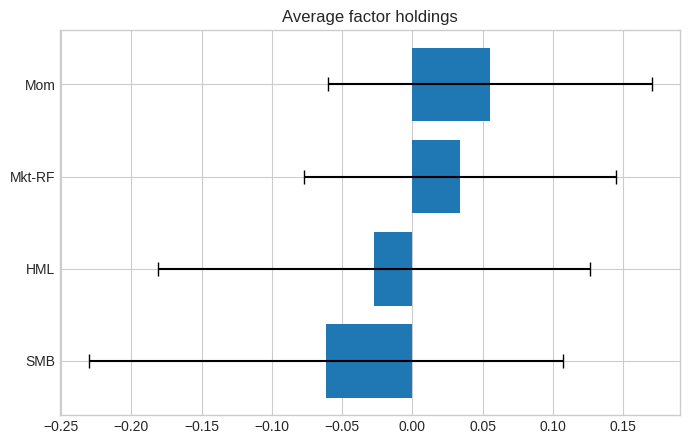

In [7]:
bar(m.h_.mean(), m.h_.std(), horizontal=True, title="Average factor holdings")

To see whether the performance is coming from factor "tilts", we decompose the pnls into the slow positions (over a one-year halflife) and the faster residual positions (defined as the difference between the positions and slow positions). This tilt/timing decomposition below shows some contribution from timing.  

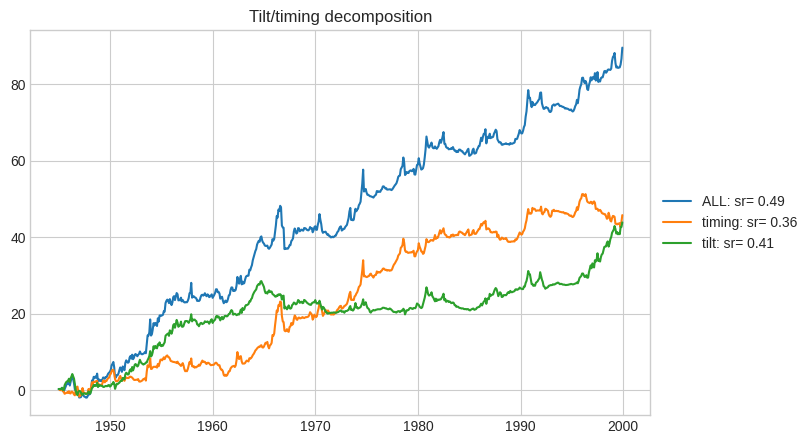

In [8]:
line(
    {
        "ALL": pnl_,
        "tilt": m.h_.ewm(halflife=12)
        .mean()
        .shift(1)
        .mul(ret)
        .sum(axis=1)
        .replace(0, np.nan)
        .dropna(),
        "timing": m.h_.sub(m.h_.ewm(halflife=12).mean())
        .shift(1)
        .mul(ret)
        .sum(axis=1)
        .replace(0, np.nan)
        .dropna(),
    },
    cumsum=True,
    title="Tilt/timing decomposition",
)